# Анализ оттока клиентов банка

# Материалы:
ссылка на презентацию:  
https://disk.yandex.ru/d/caJYb3G2B8vclQ  
ссылка на дашборд:  
https://public.tableau.com/app/profile/vadim1870/viz/Bank_16309514250910/Dashboard1

# Описание проекта:

Необходимо проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

## Загрузка данных

In [1]:
#импорты выношу в отдельную ячейку:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats as st
import math as mth
from plotly import graph_objects as go

In [2]:
#загружаем данные:
df = pd.read_csv('/datasets/bank_dataset.csv')
display(df.head())
display(df.info())
print('Пропущено {}% значений в столбце Balance'.format((df.isna().sum().sort_values(ascending=False)[0])*100/len(df)))

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

Пропущено 36.17% значений в столбце Balance


Вывод:  
данные загружены:  
Всего 10000 строк, 12 столбцов.  
Есть пропуски в стобце Balance (36.17%).  
Предполагаю, что пропуски в столбце balance вызваны техническим сбоем при выгрузке данных.  
Типы столбцов соответствуют.  
Скорректируем наименования столбцов и исследуем датафрейм.

## Предобработка данных:

In [24]:
#приведем названия столбцов к нижнему регистру:
df.columns = df.columns.str.lower()
print(df.head())

    user_id  score  age  objects    balance  products  credit_card  loyalty  \
0  15677338    619   42        2       0.00         1            1        1   
1  15690047    608   41        1   83807.86         1            0        1   
2  15662040    502   42        8  159660.80         3            1        0   
3  15744090    699   39        1       0.00         2            0        0   
4  15780624    850   43        2  125510.82         1            1        1   

   estimated_salary  churn  city_ростов великий  city_рыбинск  city_ярославль  \
0         101348.88      1                    0             0               1   
1         112542.58      0                    0             1               0   
2         113931.57      1                    0             0               1   
3          93826.63      0                    0             0               1   
4          79084.10      0                    0             1               0   

   gender_ж  gender_м  cluster_km  
0 

In [25]:
#предварительно преобразуем категориальные переменные:
df = pd.get_dummies(df)

#скорректируем названия столбцов:
df = df.rename(columns={'userid':'user_id', 'score':'score', 'age':'age', 'objects':'objects', 'balance':'balance', 'products':'products', 'creditcard':'credit_card', 'loyalty':'loyalty', 'estimated_salary':'estimated_salary', 'churn':'churn', 'city_ростов великий':'city_ростов_великий', 'city_рыбинск':'city_рыбинск', 'city_ярославль':'city_ярославль', 'gender_ж':'gender_ж', 'gender_м':'gender_м'})
#display(df.head())
display(df.info())

#проверим наличие дубликатов:
print(f"Количество дубликатов: {df.duplicated().sum()}")

#проверим наличие пропусков:
print('общее кол-во пропущенных значений:')
display(df.isnull().sum())

#сделаем два среза по оставшимся и ушедшим клиентам и изучим эти срезы:
df_stay = df[(df['churn'] == 0)]     #срез для оставшихся
#display(df_stay.head())
#display(df_stay.info())

#проверим наличие пропусков в срезе для оставшихся:
print('кол-во пропущенных значений в срезе для оставшихся:')
display(df_stay.isnull().sum())
#print(df_stay['credit_card'].value_counts())
#print(df_stay['estimated_salary'].value_counts())
print(f"Минимальное значение зарплаты в срезе для оставшихся: {df_stay['estimated_salary'].min()}")
print(f"Максимальное значение зарплаты в срезе для оставшихся: {df_stay['estimated_salary'].max()}")
print()

#срез для ушедших
df_depart = df[(df['churn'] == 1)]     #срез для ушедших
#display(df_depart.info())

#проверим наличие пропусков в срезе для ушедших:
print('кол-во пропущенных значений в срезе для ушедших:')
display(df_depart.isnull().sum())
#print(df_depart['credit_card'].value_counts())
#print(df_depart['products'].value_counts())
print(f"Минимальное значение зарплаты в срезе для ушедших: {df_depart['estimated_salary'].min()}")
print(f"Максимальное значение зарплаты в срезе для ушедших: {df_depart['estimated_salary'].max()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
user_id                10000 non-null int64
score                  10000 non-null int64
age                    10000 non-null int64
objects                10000 non-null int64
balance                10000 non-null float64
products               10000 non-null int64
credit_card            10000 non-null int64
loyalty                10000 non-null int64
estimated_salary       10000 non-null float64
churn                  10000 non-null int64
city_ростов_великий    10000 non-null uint8
city_рыбинск           10000 non-null uint8
city_ярославль         10000 non-null uint8
gender_ж               10000 non-null uint8
gender_м               10000 non-null uint8
cluster_km             10000 non-null int32
dtypes: float64(2), int32(1), int64(8), uint8(5)
memory usage: 869.3 KB


None

Количество дубликатов: 0
общее кол-во пропущенных значений:


user_id                0
score                  0
age                    0
objects                0
balance                0
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
city_ростов_великий    0
city_рыбинск           0
city_ярославль         0
gender_ж               0
gender_м               0
cluster_km             0
dtype: int64

кол-во пропущенных значений в срезе для оставшихся:


user_id                0
score                  0
age                    0
objects                0
balance                0
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
city_ростов_великий    0
city_рыбинск           0
city_ярославль         0
gender_ж               0
gender_м               0
cluster_km             0
dtype: int64

Минимальное значение зарплаты в срезе для оставшихся: 90.07
Максимальное значение зарплаты в срезе для оставшихся: 199992.48

кол-во пропущенных значений в срезе для ушедших:


user_id                0
score                  0
age                    0
objects                0
balance                0
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
city_ростов_великий    0
city_рыбинск           0
city_ярославль         0
gender_ж               0
gender_м               0
cluster_km             0
dtype: int64

Минимальное значение зарплаты в срезе для ушедших: 11.58
Максимальное значение зарплаты в срезе для ушедших: 199808.1


Вывод:  
преобразованы категориальные переменные;  
наименования столбцов скорректированы;  
дубликаты отсутствуют;  
обнаружены пропуски в столбце balance, общее кол-во пропусков - 3617,  
из них 3117 у оставшихся клиентов, 500 у ушедших.  
На данном этапе пропуски оставлю как есть, учитывая, что это NAN, который      
принадлежит к типу float, поэтому с ним можно проводить математические операции.  
Данные готовы к анализу.  

## Исследовательский анализ данных:

### Изучаем средние значения и стандартные отклонения

In [26]:
display(df.describe())

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_ростов_великий,city_рыбинск,city_ярославль,gender_ж,gender_м,cluster_km
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.501400,0.454300,0.545700,1.449000
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.500023,0.497932,0.497932,1.096138
min,1.560844e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


Вывод:  
портрет среднестатистического клиента представляет собой примерно в равной степени по количеству мужчин и женщин (мужчин немного больше), средний возраст почти 39 лет, как правило имеет не меньше двух объектов недвижимости, использует один банковкий продукт, средняя оцененная зарплата около 100 тысяч, 50% клиентов проживают соответственно в Ярославле, остальные в равных долях в Ростов Великий и Рыбинске.

### Смотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [27]:
display(df.groupby('churn').mean())

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_ростов_великий,city_рыбинск,city_ярославль,gender_ж,gender_м,cluster_km
churn,,,,,,,,,,,,,,,
0,1.573390e+07,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772,0.212859,0.259199,0.527942,0.427477,0.572523,1.498681
1,1.573279e+07,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531,0.399607,0.202749,0.397644,0.559156,0.440844,1.254786


Вывод:  
баллы кредитного скоринга в двух группах почти одинаковы;   
средний возраст различается: 37 лет у оставшегося клиента и 44 у ушедшего;  
среднее количество по имеющимся объектам недвижимости почти одинаковое;  
баланс на счетах был так же почти одинаков;  
лояльность соответственно выше у оставшихся;  
в Ростове Великом наблюдается отток, в Рыбинске отток незначительно меньше оставшихся,  
в Ярославле отток меньше чем оставшиеся клиенты;  
в группе оставшихся клиентов мужчин больше чем женщин,  
в группе ушедших наоборот.  

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [7]:
tmp = df.groupby(['loyalty', 'churn']).size().to_frame().reset_index().rename(columns={0:'size'})
tmp

,loyalty,churn,size
0,0,0,3547
1,0,1,1302
2,1,0,4416
3,1,1,735


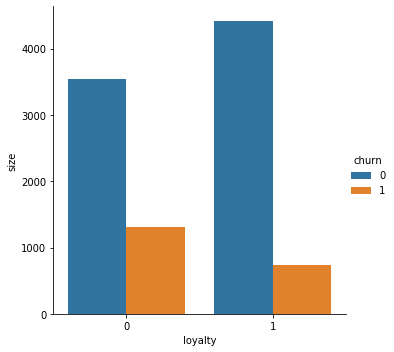

In [8]:
sns.catplot(data=tmp, kind='bar', x='loyalty', y='size', hue='churn')
# на всякий случай явно указать названия осей можно следующим образом:\
#plt.xl

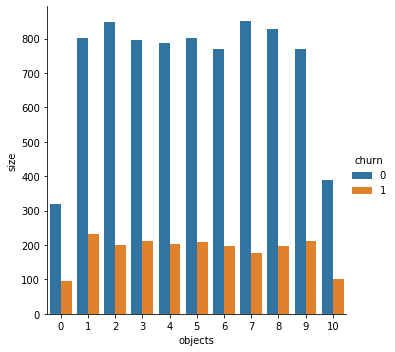

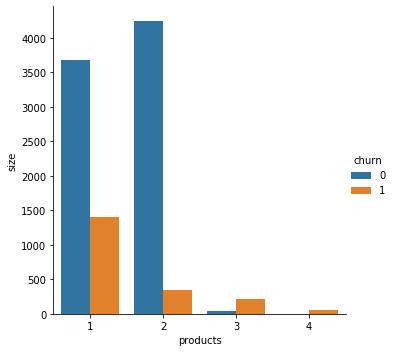

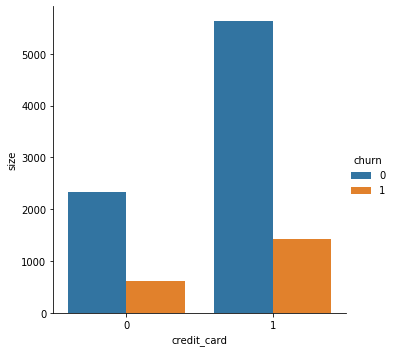

In [9]:
# создаем список необходимых признаков:
discret = ['objects', 'products', 'credit_card']

#в цикле рисуем графики:
for i in discret:
    g = df.groupby([i, 'churn']).size().to_frame().reset_index().rename(columns={0:'size'})
    sns.catplot(data=g, kind='bar', x=i, y='size', hue='churn')

Вывод:  

по признаку Loyalty — активный клиент может сказать следующее:  
из неактивных клиентов больше всего оставшихся, около 3500 клиентов, ушедших неактивных клиентов примерно 1200;  
у активных клиентов тенденция сохраняется, около 4500 клиентов оставшихся и около 700 ушедших.  

по Objects —  количеству объектов в собственности:  
почти вне зависимости от кол-ва объектов в собственности, в каждой группе (по количеству объектов) наблюдается около 800  
оставшихся киентов;  
у ушедших такая же тенденция сохраняется, но количество ушедших составляет в среднем около 200 человек.  

по Products — количество продуктов, которыми пользуется клиент:  
у оставшихся клиентов на первом месте банковский продукт № 2, на втором №1, на третьем № 3. Банковский  
продукт под № 4 никто из оставшихся клиентов не использует;
у ушедших клиентов самый популярный продукт был под № 1, на втором месте под №2, на третьем № 3 и даже использовали продукт № 4. 

по CreditCard — есть ли кредитная карта:  
оставшиеся более 5000 клиентов используют кредитную карту, из ушедших кредитной картой пользовались около 1200 человек;  
Кредитной картой не пользуются оставшиеся клиенты порядка 2200 человек, а из ушедших кредиткой не пользовались около 600 человек.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



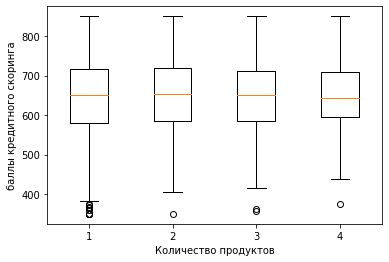

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



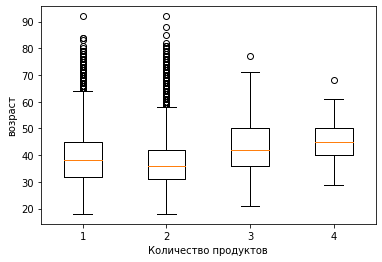

In [10]:
#строим распределения:
tmp_score = []
for tmp in df.groupby('products'):
    tmp_score.append(np.asarray([tmp[0], tmp[1]['score'].values]))
tmp_score = np.asarray(tmp_score)
plt.boxplot(tmp_score[:, 1])
plt.xlabel('Количество продуктов')
plt.ylabel('баллы кредитного скоринга')
plt.show()

tmp_age = []
for tmp in df.groupby('products'):
    tmp_age.append(np.asarray([tmp[0], tmp[1]['age'].values]))
tmp_age = np.asarray(tmp_age)
plt.boxplot(tmp_age[:, 1])
plt.xlabel('Количество продуктов')
plt.ylabel('возраст')
plt.show()

In [11]:
tmp_data = []
for tmp in df.groupby('products'):
    tmp_data.append(np.asarray([tmp[0], tmp[1]['estimated_salary'].values]))
# на выходе получили список срезов данных по количеству продуктов.
# Каждый элемент списка содержит [количество продуктов, срез зарплаты]
tmp_data = np.asarray(tmp_data)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [12]:
# Список количества продуктов
tmp_data[:, 0]

array([1, 2, 3, 4], dtype=object)

In [13]:
# Список срезов с зарплатами
tmp_data[:, 1]

array([array([101348.88, 112542.58,  79084.1 , ..., 101699.77,  42085.58,
        38190.78]),
       array([ 93826.63, 149756.71,  10062.8 , ..., 167773.55,  96270.64,
        92888.52]),
       array([113931.57, 140469.38,  93251.42, 174205.22,  85746.52,  55803.96,
        89048.46,  48559.19, 155853.52, 122381.02, 188150.6 , 187929.43,
        71905.77, 110783.28,  62256.87,  18260.98,  87822.14,  47911.03,
       191932.27, 166698.18, 110916.15,  20451.99,  16649.31,   9679.28,
       161435.02, 157908.19,  89017.38,   9217.55, 115136.51,  77294.56,
       189122.89,  10656.89, 108732.96,  83912.24,  53793.1 ,  70758.37,
        73406.04, 191734.67, 134594.99, 100615.14,  38409.79, 122066.5 ,
       100722.72, 166526.26, 185750.02,   3440.47, 125154.57,  55558.51,
        81514.06, 145071.33,  66926.83,   5862.53, 133807.77, 135875.51,
       141959.11, 174770.14, 153046.16, 178106.34,  81054.  ,  60686.4 ,
         7861.68,  76703.1 , 142342.55, 107890.69, 149097.38, 129451.29,
  

Text(0, 0.5, 'Разброс зарплаты')

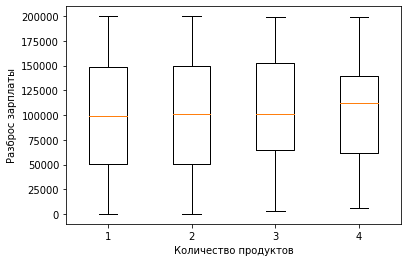

In [14]:
plt.boxplot(tmp_data[:, 1])
plt.xlabel('Количество продуктов')
plt.ylabel('Разброс зарплаты')

Вывод:  

баллы кредитного скоринга в разрезе банковских продуктов:  
средний бал по всем продуктам практически одинаковый, наблюдаются выбросы по всем продуктам ниже 400 баллов.  

возраст в разрезе банковских продуктов:  
по первому и второму банковскому продукту наблюдаются большие выбросы в возрасте начиная с 58 лет.  
возможно эти два продукта связаны с пенсионными вкладами/отчислениями? И ими так же успешно пользуются пенсионеры.  
по третьему и четвертому банковскому продукту выбросы единичны.  

разброс зарплаты в разрезе банковских продуктов:
выбросов не наблюдается.

### Построим матрицу корреляций и отобразим её

In [15]:
df_cor = pd.read_csv('/datasets/bank_dataset.csv')

Text(0.5, 1, 'Тепловая карта матрицы корреляций')

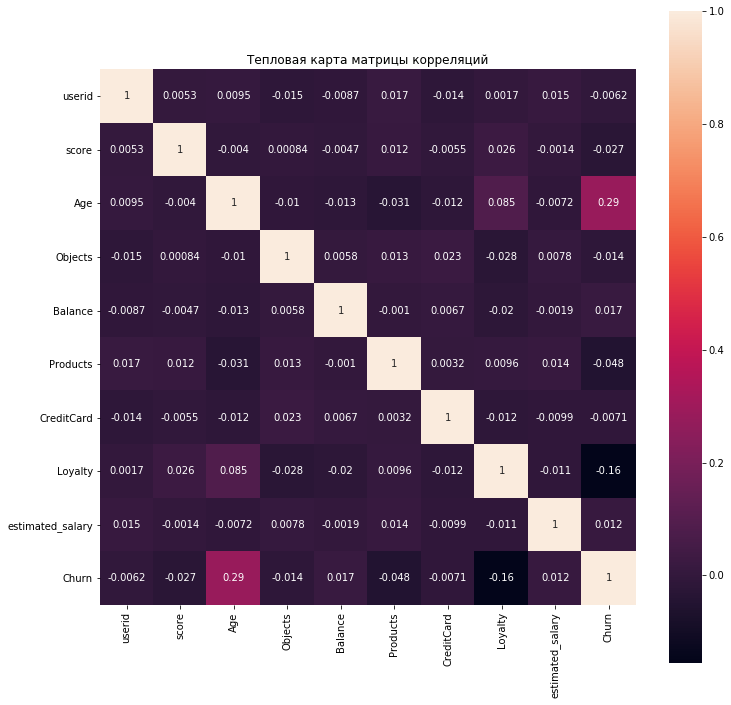

In [16]:
cm = df_cor.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot = True, square=True)
plt.title('Тепловая карта матрицы корреляций')

Вывод:   
все признаки незначительно коррелируют с целевой переменной - это хорошо.  
В основном, признаки между собой так же мало коррелируют. 

## Выделим портреты клиентов, которые склонны уходить из банка (сделаем кластеризацию клиентов)

### Стандартизируем данные и нарисуем дендрограмму

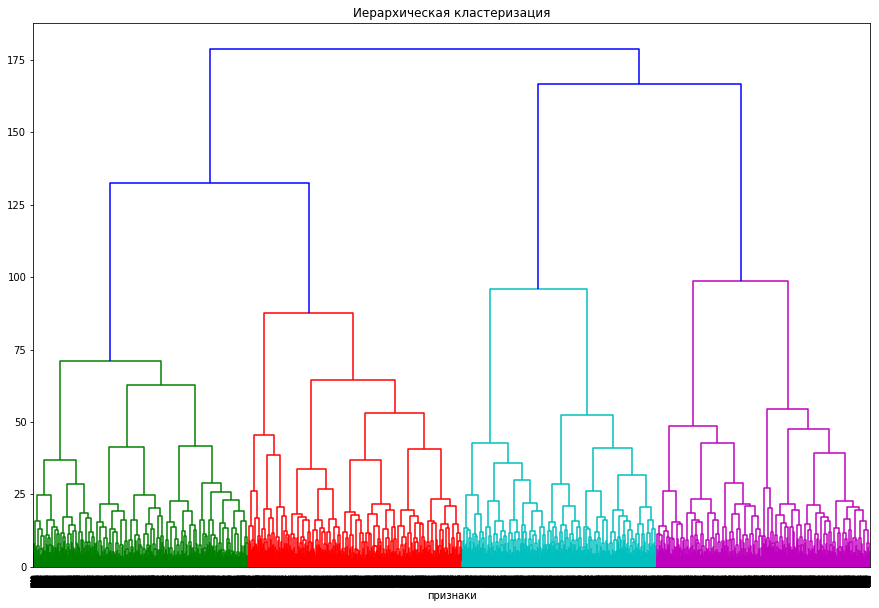

In [17]:
#предварительно заменю пропуски на нули
df['balance'] = df['balance'].fillna(0)
#display(df.head())
#display(df.info())

df_k = df.drop('churn', axis = 1) #откладываем в сторону столбец с оттоком

# стандартизируем данные
sc = StandardScaler()
# обучаем нормализатор и преобразуем набор данных
X_sc = sc.fit_transform(df_k) 
#строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и рисуем дендрограмму
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title("Иерархическая кластеризация")
plt.xlabel("признаки")
plt.show()

Вывод:  
предполагаю, что оптимальное число кластеров 4 — четыре разных цвета на графике.

### Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [28]:
km = KMeans(random_state=0, n_clusters = 4) # задаём число кластеров, равное 4
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле нашего датасета
df_k['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
display(df_k.groupby(['cluster_km']).mean())

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
cluster_km,,,,,,,,,,,,,,
0,1.573329e+07,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,1.0,0.0,0.0,0.475488,0.524512
1,1.573203e+07,650.064657,38.296404,5.049401,63546.284875,1.517254,0.713767,0.519070,100174.252495,0.0,0.0,1.0,0.000000,1.000000
2,1.573465e+07,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.0,1.0,0.0,0.439645,0.560355
3,1.573504e+07,649.185759,38.773994,4.950022,60322.670159,1.547545,0.697921,0.513932,99564.252755,0.0,0.0,1.0,1.000000,0.000000


Вывод:  
  
Профиль клиента 0:
средний возраст чуть больше 39, в среднем 5 объектов недвижимости в собственности, баланс на счету около 120 000,  
использует не меньше одного банковского продукта, не все используют кредитку, средней степени лояльности,  
оцененная зарплата около 101 000, проживает в Ростове Великом, почти равные доли между мужчинами и женщинами.  
    
Профиль клиента 1:
средний возраст около 38, в среднем 5 объектов недвижимости в собственности, баланс на счету около 63 000,  
использует не меньше одного банковского продукта, не все используют кредитку, чуть выше средней степени лояльности,  
оцененная зарплата около 100 000, проживает в Ярославле, только мужчины.    
  
Профиль клиента 2:
средний возраст около 39, в среднем 5 объектов недвижимости в собственности, баланс на счету около 61 000,  
использует не меньше одного банковского продукта, не все используют кредитку, чуть выше средней степени лояльности,  
оцененная зарплата около 99 000, проживает в Рыбинске, почти равные доли между мужчинами и женщинами.   
  
Профиль клиента 3:
средний возраст около 38, в среднем 5 объектов недвижимости в собственности, баланс на счету около 60 000,  
использует не меньше одного банковского продукта, не все используют кредитку, чуть выше средней степени лояльности,  
оцененная зарплата около 100 000, проживает в Ярославле, только женщины.

### Построим распределения признаков для кластеров

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



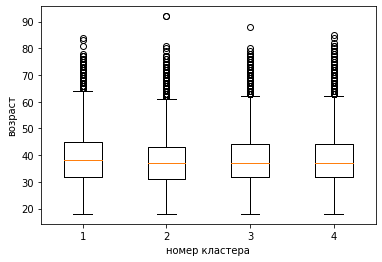

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



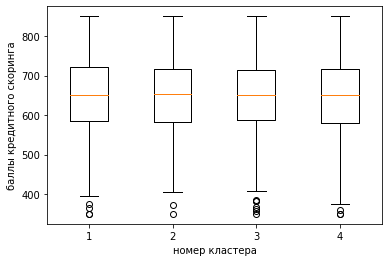

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



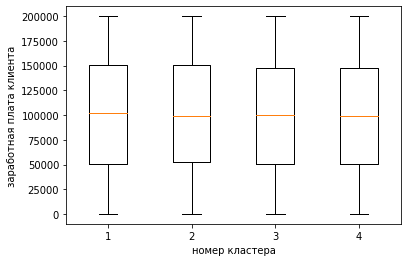

In [19]:
tmp_kl_age = []
for tmp in df_k.groupby('cluster_km'):
    tmp_kl_age.append(np.asarray([tmp[0], tmp[1]['age'].values]))
tmp_kl_age = np.asarray(tmp_kl_age)
plt.boxplot(tmp_kl_age[:, 1])
plt.xlabel('номер кластера')
plt.ylabel('возраст')
plt.show()

tmp_kl_score = []
for tmp in df_k.groupby('cluster_km'):
    tmp_kl_score.append(np.asarray([tmp[0], tmp[1]['score'].values]))
tmp_kl_score = np.asarray(tmp_kl_score)
plt.boxplot(tmp_kl_score[:, 1])
plt.xlabel('номер кластера')
plt.ylabel('баллы кредитного скоринга')
plt.show()

tmp_kl_salary = []
for tmp in df_k.groupby('cluster_km'):
    tmp_kl_salary.append(np.asarray([tmp[0], tmp[1]['estimated_salary'].values]))
tmp_kl_salary = np.asarray(tmp_kl_salary)
plt.boxplot(tmp_kl_salary[:, 1])
plt.xlabel('номер кластера')
plt.ylabel('заработная плата клиента')
plt.show()

Вывод:  
  
кластер 1 (нулевой профиль):    
средний возраст 38 лет, максимальный около 64, средний балл кредитного скоринга около 650, средняя зарплата в районе 100000;  
  
кластер 2 (первый профиль):    
средний возраст 36 лет, максимальный около 62, средний балл кредитного скоринга около 650, средняя зарплата немного ниже 100000;    
  
кластер 3 (второй профиль):    
средний возраст 36 лет, максимальный около 63, средний балл кредитного скоринга около 650, средняя зарплата в районе 100000;    
    
кластер 4 (третий профиль):    
средний возраст 36 лет, максимальный около 61, средний балл кредитного скоринга около 650, средняя зарплата в районе 100000.

### Считаем долю оттока

In [20]:
# сохраняем метки кластера в поле исходного датасета
df['cluster_km'] = labels
#display(df.info())
# выводим статистику по средним значениям наших признаков по кластеру
df_churn = df.groupby('cluster_km')['churn'].sum().reset_index()
#расчитываем долю
total = df_churn['churn'].sum()
df_churn['ratio'] = (df_churn['churn'] / total * 100).round(2)
display(df_churn)

,cluster_km,churn,ratio
0,0,814,39.96
1,1,350,17.18
2,2,413,20.27
3,3,460,22.58


Вывод:  
кластеры отличаются по доле оттока.  
Максимальная доля оттока у нулевого кластера, на следующем месте у 3-го, минимальная доля у первого:  
  
Профиль клиента 0:
средний возраст чуть больше 39, в среднем 5 объектов недвижимости в собственности, баланс на счету около 120 000,  
использует не меньше одного банковского продукта, не все используют кредитку, средней степени лояльности,  
оцененная зарплата около 101 000, проживает в Ростове Великом, почти равные доли между мужчинами и женщинами.

Профиль клиента 3:
средний возраст около 38, в среднем 5 объектов недвижимости в собственности, баланс на счету около 60 000,  
использует не меньше одного банковского продукта, не все используют кредитку, чуть выше средней степени лояльности,  
оцененная зарплата около 100 000, проживает в Ярославле, только женщины.

Попробую сравнить "портрет" полученный в результате кластеризации с данными по срезу "ушедшие" применив к срезу метод describe: 

In [21]:
display(df_depart.describe())

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
count,2.037000e+03,2037.000000,2037.000000,2037.000000,1537.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.0,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000
mean,1.573279e+07,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531,1.0,0.399607,0.202749,0.397644,0.559156,0.440844
std,7.269262e+04,100.321503,9.761562,2.936106,30555.192802,0.801521,0.458776,0.480358,57912.418071,0.0,0.489938,0.402146,0.489531,0.496610,0.496610
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567010e+07,578.000000,38.000000,2.000000,103700.690000,1.000000,0.000000,0.000000,51907.720000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.573170e+07,646.000000,45.000000,5.000000,119948.090000,1.000000,1.000000,0.000000,102460.840000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.579583e+07,716.000000,51.000000,8.000000,137986.580000,2.000000,1.000000,1.000000,152422.910000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.585839e+07,850.000000,84.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199808.100000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


Вывод:  
В целом данные схожи, различия конечно есть непосредственно по каждому профилю в уровне баланса на счету 
и местом нахождения в том или ином городе, а так же есть различия по полу. Считаю, что кластеризация проведена успешно.

## Сформулируем и проверить статистические гипотезы:

### Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.

**Нулевая гипотеза:** доход между теми клиентами, которые ушли и теми, которые остались не различается

**Альтернативная гипотеза:** доход между теми клиентами, которые ушли и теми, которые остались различается

In [22]:
alpha = 0.05 

results = st.mannwhitneyu(df_depart['estimated_salary'], df_stay['estimated_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: есть различие в доходе между теми клиентами, которые ушли и теми, которые остались')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: нет различия в доходе между теми клиентами, которые ушли и теми, которые остались'
    )

p-значение:  0.11352575465076892
Не получилось отвергнуть нулевую гипотезу: нет различия в доходе между теми клиентами, которые ушли и теми, которые остались


Вывод:  
Не получилось отвергнуть нулевую гипотезу: нет различия в доходе между теми клиентами, которые ушли и теми, которые остались   

### Проверим гипотезу различия количества недвижимости в собственности между теми клиентами, которые ушли и теми, которые остались.

Для проверки гипотезы выбираю непараметрический тест Уилкоксона-Манна-Уитни, так как данные не являются бинарными, 
имеют не нормальное распределение.

**Нулевая гипотеза:** количество недвижимости между теми клиентами, которые ушли и теми, которые остались не различается

**Альтернативная гипотеза:** количество недвижимости между теми клиентами, которые ушли и теми, которые остались различается

In [23]:
alpha = 0.05 

results = st.mannwhitneyu(df_depart['objects'], df_stay['objects'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: есть различие в количестве недвижимости между теми клиентами, которые ушли и теми, которые остались')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу: нет различия в количестве недвижимости между теми клиентами, которые ушли и теми, которые остались'
    )

p-значение:  0.08109688061459414
Не получилось отвергнуть нулевую гипотезу: нет различия в количестве недвижимости между теми клиентами, которые ушли и теми, которые остались


Вывод:  
Не получилось отвергнуть нулевую гипотезу: нет различия в количестве недвижимости между теми клиентами,
которые ушли и теми, которые остались

## Общий вывод

В результате исследования можно выделить следубщие портреты клиентов, которые склонны уходить из банка:
  
Профиль клиента 0:
средний возраст чуть больше 39, максимальный возраст порядка 64 лет, в среднем 5 объектов недвижимости в собственности, баланс на счету около 120 000,  
использует не меньше одного банковского продукта, не все используют кредитку, средней степени лояльности,  
оцененная зарплата около 101 000, проживает в Ростове Великом, почти равные доли между мужчинами и женщинами.

Профиль клиента 3:
средний возраст около 38, максимальный возраст около 61 года, в среднем 5 объектов недвижимости в собственности, баланс на счету около 60 000,  
использует не меньше одного банковского продукта, не все используют кредитку, чуть выше средней степени лояльности,  
оцененная зарплата около 100 000, проживает в Ярославле, только женщины.

Рекомендации по профилю 0:  
пересмотреть банковские продукты, сделать их более доступными, активнее их предлагать, например бесплатная доставка и оформление на дом кредитной карты, или подключение к скидочной системе больше компаний партнеров.   
 
  
Рекомендации по профилю 3:  
В дополнение к рекомендациям по профилю 0 - активнее распостранять банковские продукты среди мужчин.

По результатам проверки двух гипотез, выяснилось, что на отток клиентов не влияет уровень дохода и количество в собственности
объектов недвижимости. При равных этих двух параметров клиенты всеравно склонны к оттоку.